In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime

from healforcescpecg import *

from biosppy.signals.ecg import ecg
import biosppy.signals.tools as st
from biosppy.plotting import plot_ecg
import pyhrv
from pyhrv.hrv import hrv
import pyhrv.tools as tools
#from ecgdetectors import Detectors

In [2]:
basepath = "./demodata"
sampling_rate = 150.
all_samples = []
all_beats = []
n_samples = 0

for i in range(62,64):
    j = int(i / 450)
    fn = '{}/ECG_{:d}/{:d}.SCP'.format(basepath,j,i)
    scp = HealforceSCPECG(fn)
    samples = scp.samples
    beats = scp.beats.sum(axis=1) > 0
    beat_idx = np.arange(n_samples,n_samples+len(beats),1, dtype=np.uint32)[beats].reshape(-1,1)
    beat_markers = np.array(scp.irregular_beat_markers, dtype=np.uint8).reshape(-1,1)
    n = min(len(beat_idx),len(beat_markers))
    if len(beat_idx) != len(beat_markers):
        print("number of beats does not match", i, beat_idx.shape, beat_markers.shape)
        pass
    beats = np.concatenate( (beat_idx[:n], beat_markers[:n]), axis=1 )
    n_samples += len(samples)
    all_samples.append(samples)
    all_beats.append(beats)

samples = np.concatenate(all_samples,axis=0) / 100
beats = np.concatenate(all_beats,axis=0)
rpeaks = beats[:,0]
hr_idx, hr = st.get_heart_rate(beats=rpeaks, sampling_rate=sampling_rate, smooth=True, size=3)
heart_rates = np.concatenate((hr_idx.reshape(-1,1), hr.reshape(-1,1)), axis=1)
startdate = pd.to_datetime(datetime(*scp.patient_info['startdate'], *scp.patient_info['starttime']))
num_leads = scp.num_leads
nni = tools.check_input(None, [float((x*1000)/sampling_rate) for x in rpeaks])

resample_rate = '30s'
heart_rate_datetime_idx = pd.to_timedelta(heart_rates[:,0]/sampling_rate, unit='s') + startdate
heart_rate = pd.Series(heart_rates[:,1], index=heart_rate_datetime_idx)
heart_rate_df = pd.DataFrame({'mean': heart_rate.resample(resample_rate).mean(),
                              'min': heart_rate.resample(resample_rate).min(),
                              'max': heart_rate.resample(resample_rate).max()})

Text(0.5, 0.98, 'heart rate overview 2019-08-08')

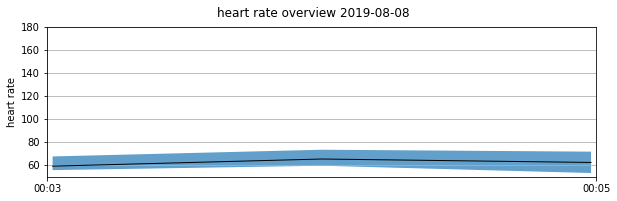

In [3]:
fig = plt.figure(figsize=((1/25.4)*250, (1/25.4)*70))
axtl = plt.gca()
axtl.fill_between(mdates.date2num(heart_rate_df.index.values), heart_rate_df['min'], heart_rate_df['max'],alpha=0.7)
axtl.plot(mdates.date2num(heart_rate_df.index.values), heart_rate_df['mean'],lw=1,color='k')
axtl.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axtl.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0]))
axtl.set_ylabel("heart rate")
if heart_rate_df.index[0].hour < 12:
    start_section = (heart_rate_df.index[0] - pd.to_timedelta(heart_rate_df.index[0].hour+1, 'h')).floor('2h')
else:
    start_section = heart_rate_df.index[0].floor('2h')
end_section = heart_rate_df.index[-1].ceil('12h')
#axtl.set_xlim(mdates.date2num([start_section, end_section]))
axtl.set_ylim(50, 180)
plt.margins(x=0.01)
plt.grid()
plt.suptitle('heart rate overview {}'.format(startdate.strftime('%Y-%m-%d')))

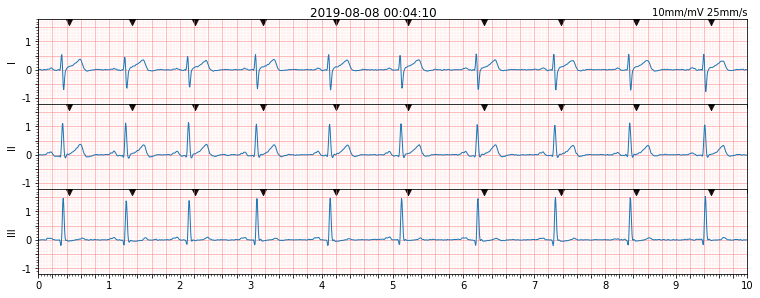

In [4]:
# based on https://github.com/dy1901/ecg_plot

seconds = 10
fig = plt.figure(figsize=((1/25.4)*(25*seconds)/0.93, (1/25.4)*3*10*(num_leads)/0.86))

lead_index = ['I', 'II', 'III']
leads = len(lead_index)
start_idx = 0
end_idx = int(seconds*sampling_rate)
axs = fig.subplots(leads, 1, sharex=True, sharey=True,
                   subplot_kw={'autoscale_on': False, 'autoscaley_on': False, 'autoscalex_on': False, 'xmargin': 0, 'ylim': (-1.2, 1.8), 'xlim': (0., seconds)},
                   gridspec_kw={'hspace': 0, 'left': 0.06, 'right': 0.99, 'top': 0.94, 'bottom': 0.08})
ax = axs[0]
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xticks(np.arange(0,seconds+0.2,0.2))
ax.set_xticklabels(["{:d}".format(int(x)) if (x-int(x) == 0) else "" for x in ax.get_xticks()])
ax.set_yticks(np.arange(-1,1.8,0.5))
ax.set_yticklabels(["{:d}".format(int(x)) if (x-int(x) == 0) else "" for x in ax.get_yticks()])
#ax.minorticks_on()
fig.text(0.865,0.95, "10mm/mV 25mm/s")

lead_ts = np.array(np.arange(0, seconds, 1/sampling_rate))
for ax, lead_index in zip(axs, lead_index):
    ax.set_aspect(10/25)
    ax.grid(which='major', linestyle='-', linewidth='0.5', color=(1, 0.5, 0.5))
    ax.grid(which='minor', linestyle=':', linewidth='0.3', color=(1, 0.6, 0.6))
    if num_leads > 1:
        ax.set_ylabel(lead_index)
    else:
        ax.set_ylabel("")

fig.suptitle(startdate)

def get_beats(start_idx, end_idx):
    start_idx = np.min(np.where(beats[:,0] >= start_idx))
    end_idx = np.max(np.where(beats[:,0] < end_idx))+1
    return beats[start_idx:end_idx, :]

beats = get_beats(start_idx, end_idx)

for i in range(0, len(lead_index)):
    if num_leads > 1:
        s = samples[start_idx:end_idx,i]
        n = min(len(lead_ts), len(s))
    else:
        s = samples[start_idx+(i*seconds*150):end_idx+(i*seconds*150),0]
        n = min(len(lead_ts), len(s))
        if i > 0:
            beats = get_beats(start_idx+(i*seconds*150), end_idx+(i*seconds*150))
    b = lead_ts[beats[:, 0]-(start_idx)]
    lead_line, = axs[i].plot(lead_ts[:n], s[:n], linewidth=1.0)
    beat_marker = axs[i].scatter(b, [1.7]*len(b), marker='v', color='k')

/home/kaba/src/scpecg/venv/lib/python3.7/site-packages/pyhrv/nonlinear.py:280: UserWarning: Not enough NNI samples for Detrended Fluctuations Analysis.
  warnings.warn("Not enough NNI samples for Detrended Fluctuations Analysis.")


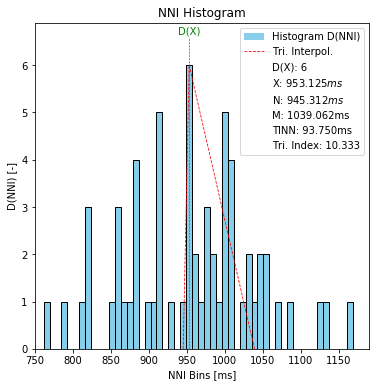

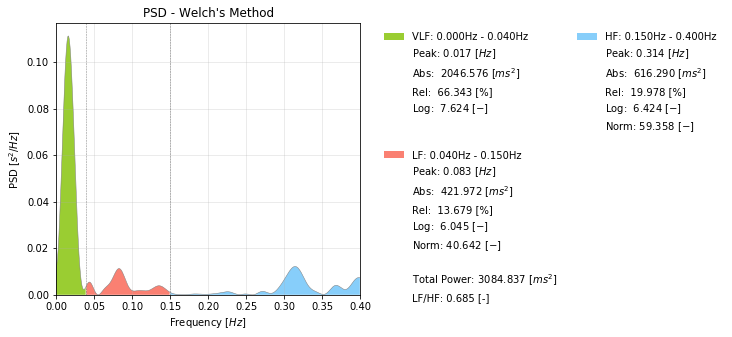

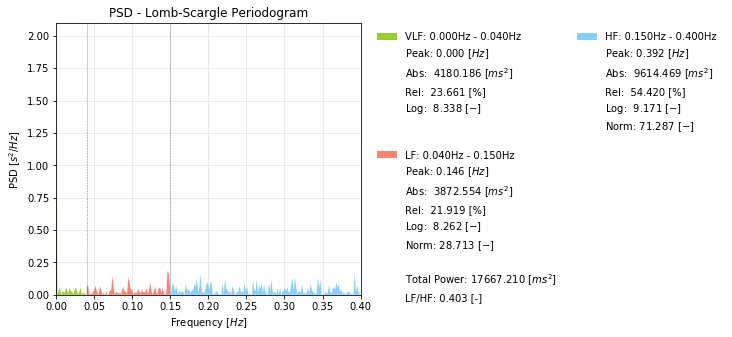

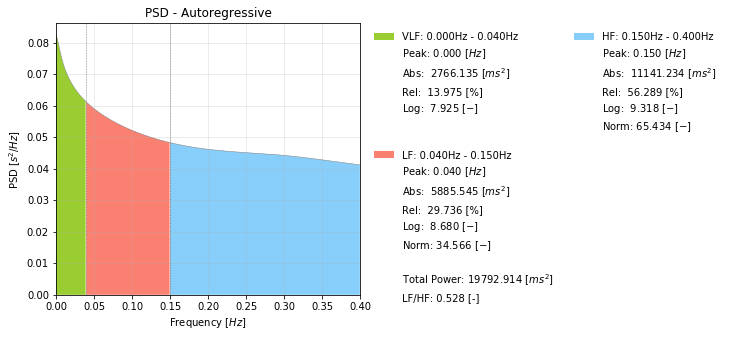

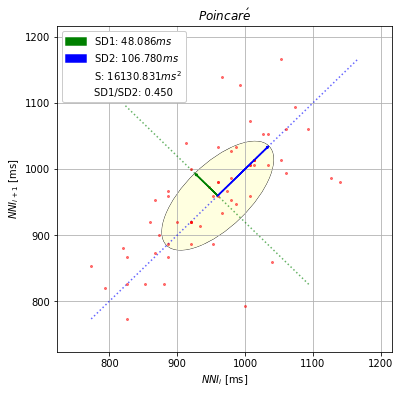

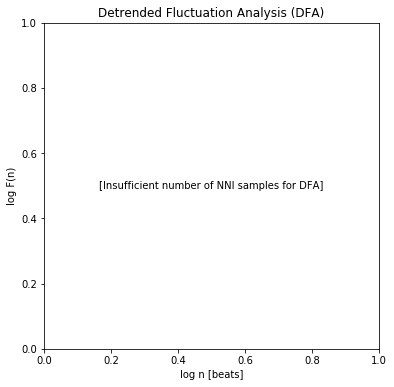

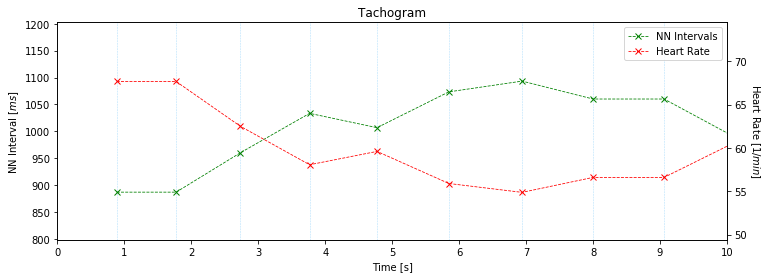

ReturnTuple(nni_counter=62, nni_mean=959.7849462365591, nni_min=773.3333333333358, nni_max=1166.6666666666642, hr_mean=63.00707387170972, hr_min=51.42857142857154, hr_max=77.58620689655147, hr_std=5.682567696293791, nni_diff_mean=46.775956284153075, nni_diff_min=0, nni_diff_max=206, sdnn=85.19530966963843, sdnn_index=nan, sdann=nan, rmssd=68.15817882410917, sdsd=49.985061520694515, nn50=21, pnn50=34.42622950819672, nn20=38, pnn20=62.295081967213115, nni_histogram=<Figure size 432x432 with 1 Axes>, tinn_n=945.3125, tinn_m=1039.0625, tinn=93.75, tri_index=10.333333333333334, fft_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), fft_peak=(0.0166015625, 0.0830078125, 0.314453125), fft_abs=(2046.575796546769, 421.97160613146474, 616.2900445277145), fft_rel=(66.34306771659651, 13.678892757012532, 19.97803952639097), fft_log=(7.623923332406027, 6.044938027723677, 6.423717704223764), fft_norm=(40.64212579397113, 59.35787420602887), fft_ratio=0.6846964507674904, fft

In [5]:
hrv(nni=nni, sampling_rate=sampling_rate, show=True)